In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import json
import numpy as np
import folium

In [2]:
data_dir = '../data/routes.csv'
df = pd.read_csv(data_dir, sep='\t')
df.head()

passenger_id  source_latitude  source_longitude  \
0         41037       -12.088156        -77.016065   
1        116591       -12.099957        -77.036497   
2         86426       -12.099153        -77.019425   
3         53610       -12.110271        -77.028945   
4        102927       -12.098430        -77.026246   

                                   source_address  destination_latitude  \
0  Avenida Nicolás de Arriola 314, La Victoria 13            -12.108531   
1     Av Los Conquistadores 392, San Isidro 15073            -12.119686   
2     Av. República de Panamá 3537, San Isidro 27            -12.076505   
3                           Junín 225, Miraflores            -12.132221   
4       Av. República De Colombia 791, San Isidro            -12.099529   

   destination_longitude                             destination_address  \
0             -77.044891  Calle Carlos Graña Elisande 340, San Isidro 27   
1             -76.999969            Bruselas 228, La Calera De La Merced   
2             -77.089305           Av. La Marina cdra. 25, San Miguel 32   
3             -77.027021           Calle San Fernando 380, Miraflores 18   
4             -76.990486                  Calle Mozart 201, San Borja 41   

          request_date  
0  2015-09-01 00:00:04  
1  2015-09-01 00:00:15  
2  2015-09-01 00:00:17  
3  2015-09-01 00:00:29  
4  2015-09-01 00:00:31

In [3]:
df.tail()

passenger_id  source_latitude  source_longitude  \
2045255        304744       -12.060781        -77.111638   
2045256        290386       -12.070189        -77.106793   
2045257         98815       -12.053719        -76.973228   
2045258        196924       -12.116891        -77.045441   
2045259         24694       -12.093108        -77.031319   

                                 source_address  destination_latitude  \
2045255      Jirón Lola Vilar 240, Bellavista 2            -12.083261   
2045256            Av. La Marina s/n, El Callao            -12.105407   
2045257       Calle Mineria 320, Santa Anita 43            -12.107983   
2045258   Calle Manuel Tovar 181, Miraflores 18            -12.129407   
2045259  Calle Virrey Toledo 379, San Isidro 27            -12.048219   

         destination_longitude                    destination_address  \
2045255             -77.067139                    Sucre, Pueblo Libre   
2045256             -77.013802            Calle 26 142, San Isidro 27   
2045257             -77.013924            Calle 32 176, San Isidro 27   
2045258             -77.032799   Calle Diego Ferre 218, Miraflores 18   
2045259             -77.000381  Av. Riva Agüero 1358, 10, El Agustino   

                request_date  
2045255  2015-12-30 23:59:52  
2045256  2015-12-30 23:59:53  
2045257  2015-12-30 23:59:55  
2045258  2015-12-30 23:59:55  
2045259  2015-12-31 00:00:00

In [4]:
df = df.dropna()
df.shape

(2036062, 8)

We observe that our data contain some rows with NaN values after dropping them off. Latitude and longitude columns for source and destination respectively are merged, to check the number of unique sources and destinations.

In [5]:
df['source'] = df['source_latitude'].map(str) + ',' + df['source_longitude'].map(str)
df['destination'] = df['destination_latitude'].map(str) + ',' + df['destination_longitude'].map(str)
df.head()

passenger_id  source_latitude  source_longitude  \
0         41037       -12.088156        -77.016065   
1        116591       -12.099957        -77.036497   
2         86426       -12.099153        -77.019425   
3         53610       -12.110271        -77.028945   
4        102927       -12.098430        -77.026246   

                                   source_address  destination_latitude  \
0  Avenida Nicolás de Arriola 314, La Victoria 13            -12.108531   
1     Av Los Conquistadores 392, San Isidro 15073            -12.119686   
2     Av. República de Panamá 3537, San Isidro 27            -12.076505   
3                           Junín 225, Miraflores            -12.132221   
4       Av. República De Colombia 791, San Isidro            -12.099529   

   destination_longitude                             destination_address  \
0             -77.044891  Calle Carlos Graña Elisande 340, San Isidro 27   
1             -76.999969            Bruselas 228, La Calera De La Merced   
2             -77.089305           Av. La Marina cdra. 25, San Miguel 32   
3             -77.027021           Calle San Fernando 380, Miraflores 18   
4             -76.990486                  Calle Mozart 201, San Borja 41   

          request_date                          source  \
0  2015-09-01 00:00:04           -12.088156,-77.016065   
1  2015-09-01 00:00:15           -12.099957,-77.036497   
2  2015-09-01 00:00:17           -12.099153,-77.019425   
3  2015-09-01 00:00:29  -12.110271000000001,-77.028945   
4  2015-09-01 00:00:31            -12.09843,-77.026246   

                              destination  
0                   -12.108531,-77.044891  
1                   -12.119686,-76.999969  
2  -12.076505000000001,-77.08930500000001  
3  -12.132221000000001,-77.02702099999999  
4          -12.099528999999999,-76.990486

By using latitude and longitude we can add the **distance** feature between source and destination for each request. It's not the distance that the taxi will go through, but the distance between 2 points in 2 dimensions.

In [6]:
from math import sin, cos, sqrt, atan2, radians
def add_distance(row):
    # approximate radius of earth in km
    R = 6373.0
    lon2 = radians(abs(row['destination_longitude']))
    lon1 = radians(abs(row['source_longitude']))
    lat2 = radians(abs(row['destination_latitude']))
    lat1 = radians(abs(row['source_latitude']))
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

df['distance'] = df.apply(lambda row: add_distance(row), axis=1)

Generally, latitude and longitude values are 2 features that represent the 3 dimensional space. The lowest and the highest values are too close and this can be proven problematic during training. We can map latitude and longitude values into x, y and z for source-destination respectively and close points in these 3 dimensions are also close in reality. Depending on the use case you can disregard the changes in height and map them to a perfect sphere. In this way, we enrich our data with 6 more features (xyz for source and destination) and we will see the effect on our model after experimentation.

In [7]:
def add_source_x(row, R):
    lat = radians(row['source_latitude'])
    lon = radians(row['source_longitude'])
    x = R * cos(lat) * cos(lon)
    return x

def add_source_y(row, R):
    lat = radians(row['source_latitude'])
    lon = radians(row['source_longitude'])
    y = R * cos(lat) * sin(lon)
    return y

def add_source_z(row, R):
    lat = radians(row['source_latitude'])
    lon = radians(row['source_longitude'])
    z = R * sin(lat) 
    return z

def add_dest_x(row, R):
    lat = radians(row['destination_latitude'])
    lon = radians(row['destination_longitude'])
    x = R * cos(lat) * cos(lon)
    return x

def add_dest_y(row, R):
    lat = radians(row['destination_latitude'])
    lon = radians(row['destination_longitude'])
    y = R * cos(lat) * sin(lon)
    return y

def add_dest_z(row, R):
    lat = radians(row['destination_latitude'])
    z = R * sin(lat) 
    return z

R = 6373.0
df['source_x'] = df.apply(lambda row: add_source_x(row, R), axis=1)
df['source_y'] = df.apply(lambda row: add_source_y(row, R), axis=1)
df['source_z'] = df.apply(lambda row: add_source_z(row, R), axis=1)
df['destination_x'] = df.apply(lambda row: add_dest_x(row, R), axis=1)
df['destination_y'] = df.apply(lambda row: add_dest_y(row, R), axis=1)
df['destination_z'] = df.apply(lambda row: add_dest_z(row, R), axis=1)
    

In [8]:
df.head()

passenger_id  source_latitude  source_longitude  \
0         41037       -12.088156        -77.016065   
1        116591       -12.099957        -77.036497   
2         86426       -12.099153        -77.019425   
3         53610       -12.110271        -77.028945   
4        102927       -12.098430        -77.026246   

                                   source_address  destination_latitude  \
0  Avenida Nicolás de Arriola 314, La Victoria 13            -12.108531   
1     Av Los Conquistadores 392, San Isidro 15073            -12.119686   
2     Av. República de Panamá 3537, San Isidro 27            -12.076505   
3                           Junín 225, Miraflores            -12.132221   
4       Av. República De Colombia 791, San Isidro            -12.099529   

   destination_longitude                             destination_address  \
0             -77.044891  Calle Carlos Graña Elisande 340, San Isidro 27   
1             -76.999969            Bruselas 228, La Calera De La Merced   
2             -77.089305           Av. La Marina cdra. 25, San Miguel 32   
3             -77.027021           Calle San Fernando 380, Miraflores 18   
4             -76.990486                  Calle Mozart 201, San Borja 41   

          request_date                          source  \
0  2015-09-01 00:00:04           -12.088156,-77.016065   
1  2015-09-01 00:00:15           -12.099957,-77.036497   
2  2015-09-01 00:00:17           -12.099153,-77.019425   
3  2015-09-01 00:00:29  -12.110271000000001,-77.028945   
4  2015-09-01 00:00:31            -12.09843,-77.026246   

                              destination  distance     source_x     source_y  \
0                   -12.108531,-77.044891  3.868460  1400.122360 -6072.363628   
1                   -12.119686,-76.999969  4.538403  1397.895137 -6072.594525   
2  -12.076505000000001,-77.08930500000001  8.007005  1399.708692 -6072.196002   
3  -12.132221000000001,-77.02702099999999  2.450444  1398.641537 -6072.175779   
4          -12.099528999999999,-76.990486  3.891145  1398.989578 -6072.379018   

      source_z  destination_x  destination_y  destination_z  
0 -1334.610935    1396.960637   -6072.604367   -1336.826907  
1 -1335.894425    1401.662778   -6071.253519   -1338.040046  
2 -1335.806983    1392.419652   -6074.412818   -1333.343704  
3 -1337.016140    1398.730351   -6071.629227   -1339.403203  
4 -1335.728350    1402.773490   -6071.479720   -1335.847876

In [9]:
df = df.dropna()
df.shape

(2036062, 17)

In [10]:
print("Num unique passengers: {}".format(len(df['passenger_id'].unique())))
print("Num unique sources (coordinates): {}".format(len(df['source'].unique())))
print("Num unique destinations (coordinates): {}".format(len(df['destination'].unique())))
print("Num unique sources (addresses): {}".format(len(df['source_address'].unique())))
print("Num unique destinations (addresses): {}".format(len(df['destination_address'].unique())))

Num unique passengers: 118256
Num unique sources (coordinates): 585643
Num unique destinations (coordinates): 240840
Num unique sources (addresses): 317873
Num unique destinations (addresses): 201128


Let's view the top 10 and the last 10 passengers according to requests:

In [11]:
df.passenger_id.value_counts()[:10]

76772     1752
188719    1499
124189    1289
95667     1233
28420     1044
77779      983
22330      957
68454      918
116915     896
244915     892
Name: passenger_id, dtype: int64

In [12]:
df.passenger_id.value_counts()[-10:]

242367    1
32576     1
299280    1
24746     1
264451    1
235325    1
255795    1
259583    1
198855    1
114299    1
Name: passenger_id, dtype: int64

We convert date into datetime pandas object and we add **hour** feature to plot the frequency of requests in each hour.

In [13]:
df.request_date = df.request_date.apply(pd.to_datetime)

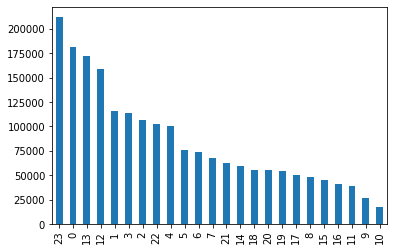

In [14]:
df['hour'] = df.request_date.dt.hour
df.hour.value_counts().plot(kind='bar')

Now let's view the frequency of requests per day. We see that Friday is the day with the most requests in our dataset.

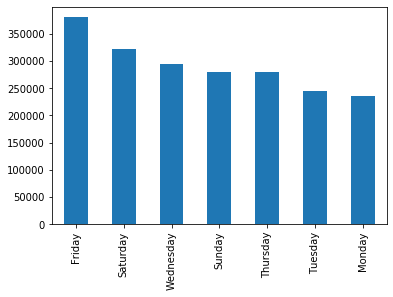

In [15]:
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['weekday'] = df['request_date'].dt.dayofweek.map(dayOfWeek)
df.weekday.value_counts().plot(kind='bar')

Now we will check the top 10 and the last 10 sources and destinations. We check addresses seperately from latitudes and longitudes, because the same address can belong to different longitudes and latitudes (same address in different region). So source and destination features that are defined by latitude and longitude are more reliable. We can clearly observe that our dataset contains addresses that have high frequency of requests and also addresses that take part in only 1 request!

In [16]:
df.source_address.value_counts()[:10]

Av. Elmer Faucett s/n, Lima                               8707
Costa Verde, Magdalena Del Mar                            3527
Avenida República de Panamá 3055, San Isidro 27           1980
Calle Las Begonias 415, San Isidro 27                     1835
Av. Javier Prado Este 4200, Santiago de Surco, Lima 33    1735
Avenida República de Colombia 791, San Isidro 27          1675
Bajada Circuito de Playas, Magdalena Del Mar              1557
Avenida Paseo de la República 3755, San Isidro 27         1410
Jr. Daniel Alomía Robles 125, Surco 33                    1376
Av. Salaverry 2370, Jesús María 00011                     1367
Name: source_address, dtype: int64

In [17]:
df.source_address.value_counts()[-10:]

Av Simón Bolivar 1509, Lima                                        1
Jirón Carlos A. Salaverry 324, La Perla 4                          1
Jirón Los Ruibarbos 144, San Juan de Lurigancho 36                 1
Calle Rancho 252, La Molina 12                                     1
Jirón Coronel León Velarde 215, Lince 14                           1
Calle Monte Rosa 288, Santiago de Surco 33                         1
Avenida Circ. del Club Golf Los Incas 963, Santiago de Surco 33    1
Jirón Loreto 1199, Breña 5                                         1
Avenida Tacna 336, San Miguel 32                                   1
Av San Luis 1996, Lima                                             1
Name: source_address, dtype: int64

In [18]:
df.destination_address.value_counts()[:10]

Av. Elmer Faucett s/n, Lima                                30339
Av. Javier Prado Este 4200, Santiago de Surco, Lima 33      6790
Av. La Marina 2000, San Miguel 32                           6102
Av. Salaverry 2370, Jesús María 00011                       5546
Av. Javier Prado Este 4200, Santiago de Surco, 33, Lima     4148
Av. Universitaria 1801, San Miguel 32                       3992
Av. Prolongación Primavera 2390, Surco Lima 33              3597
Av. Javier Prado Cuadra 46, Surco 33                        3417
Malecón de la Reserva 610, Miraflores 18                    3248
Av. Javier Prado Este 2050, San Borja 41                    3171
Name: destination_address, dtype: int64

In [19]:
df.destination_address.value_counts()[-10:]

Jimenez 497, Magdalena del Mar 15073                   1
Calle Los Gladiolos 359, Miraflores 18                 1
Avenida Alfredo Benavides 655, Miraflores 18           1
Calle César Vallejo, San Miguel 32                     1
Calle Vizcardo y Guzman 393, Santiago de Surco 33      1
Calle Pedro Ruíz 200, Villa María del Triunfo 35       1
Jirón Joaquín Bernal 417, San Juan de Miraflores 29    1
Avenida Central, 190                                   1
Los Ingenieros 787, Lima                               1
Av San Luis 1996, Lima                                 1
Name: destination_address, dtype: int64

In [20]:
df.source.value_counts()[:10]

-12.022636,-77.108145             6056
-12.098410000000001,-77.072439    2377
-12.022636,-77.108147             1803
-12.085999000000001,-76.977071    1759
-12.094088000000001,-77.020898    1407
-12.089933,-77.052312             1373
-12.105291000000001,-76.95498     1306
-12.098459,-77.026372             1299
-12.103127,-77.062728             1258
-12.093914,-77.02145300000001     1196
Name: source, dtype: int64

In [21]:
df.source.value_counts()[-10:]

-12.06048,-77.07070999999999              1
-12.098718,-77.01084                      1
-12.100813,-76.97774799999999             1
-12.106172,-76.965552                     1
-12.088784,-77.052252                     1
-12.096950999999999,-77.02419599999999    1
-12.095589,-77.073921                     1
-12.11144,-76.98366999999999              1
-12.131083,-77.02771                      1
-12.07663,-76.993219                      1
Name: source, dtype: int64

In [22]:
df.destination.value_counts()[:10]

-12.022636,-77.108145             19122
-12.022636,-77.108147             11649
-12.084436,-76.971588              7206
-12.085999000000001,-76.977071     6924
-12.07731,-77.082396               6236
-12.089933,-77.052312              5724
-12.085999000000001,-76.977074     4552
-12.068699,-77.079091              4256
-12.104284,-76.96319799999999      3701
-12.08943,-77.004633               3273
Name: destination, dtype: int64

In [23]:
df.destination.value_counts()[-10:]

-12.083293,-77.091263             1
-12.078265,-76.987511             1
-12.073657,-76.947128             1
-12.10388,-77.038682              1
-12.096757,-77.043953             1
-11.93993,-77.05667               1
-12.094444000000001,-77.025361    1
-12.079684,-77.060959             1
-12.10346,-76.972954              1
-12.061483,-77.047732             1
Name: destination, dtype: int64

Now we keep only the features that can give us important information, which are the passengers, the latitude-longitude and cartesians xyz of source-destination respectively, the 2d distance (measured in km) between source-distance and of course the timestamp.

In [24]:
data = df[['passenger_id',
           'source_latitude',
           'source_longitude',
           'source_x',
           'source_y',
           'source_z',
           'destination_latitude',
           'destination_longitude',
           'destination_x',
           'destination_y',
           'destination_z',
           'distance' ,
           'request_date']]
data.head()

passenger_id  source_latitude  source_longitude     source_x     source_y  \
0         41037       -12.088156        -77.016065  1400.122360 -6072.363628   
1        116591       -12.099957        -77.036497  1397.895137 -6072.594525   
2         86426       -12.099153        -77.019425  1399.708692 -6072.196002   
3         53610       -12.110271        -77.028945  1398.641537 -6072.175779   
4        102927       -12.098430        -77.026246  1398.989578 -6072.379018   

      source_z  destination_latitude  destination_longitude  destination_x  \
0 -1334.610935            -12.108531             -77.044891    1396.960637   
1 -1335.894425            -12.119686             -76.999969    1401.662778   
2 -1335.806983            -12.076505             -77.089305    1392.419652   
3 -1337.016140            -12.132221             -77.027021    1398.730351   
4 -1335.728350            -12.099529             -76.990486    1402.773490   

   destination_y  destination_z  distance        request_date  
0   -6072.604367   -1336.826907  3.868460 2015-09-01 00:00:04  
1   -6071.253519   -1338.040046  4.538403 2015-09-01 00:00:15  
2   -6074.412818   -1333.343704  8.007005 2015-09-01 00:00:17  
3   -6071.629227   -1339.403203  2.450444 2015-09-01 00:00:29  
4   -6071.479720   -1335.847876  3.891145 2015-09-01 00:00:31

Now let's plot them and check for outliers

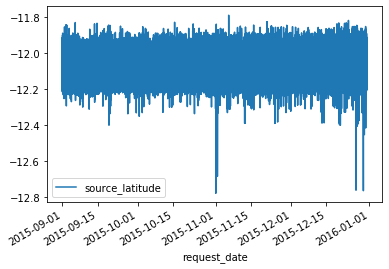

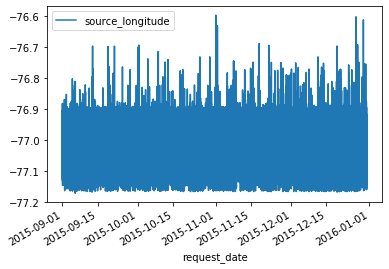

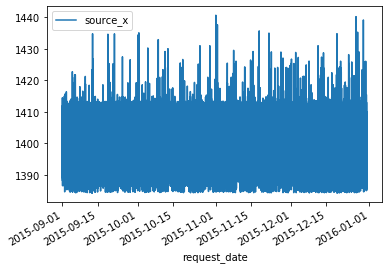

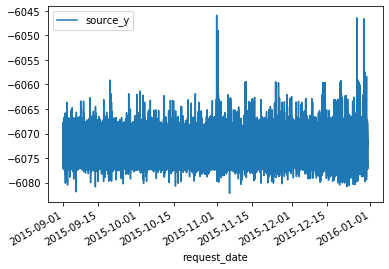

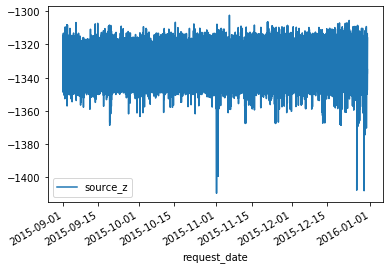

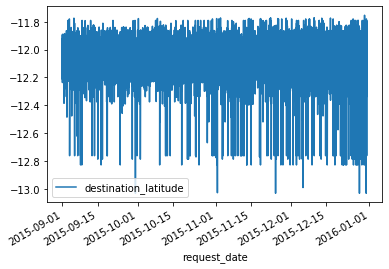

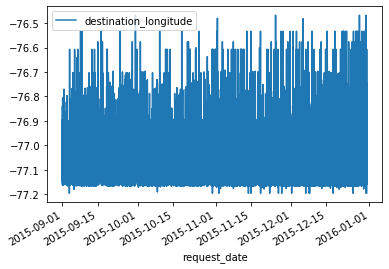

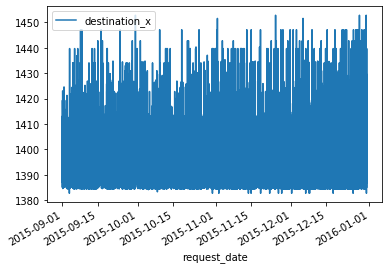

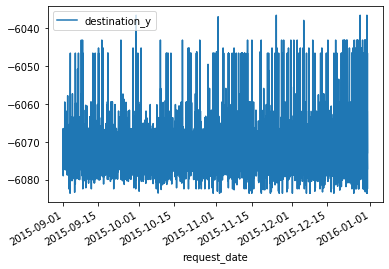

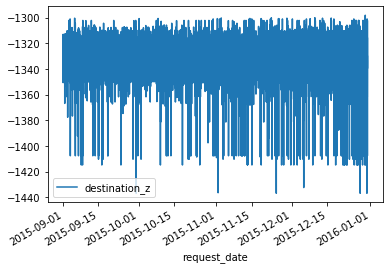

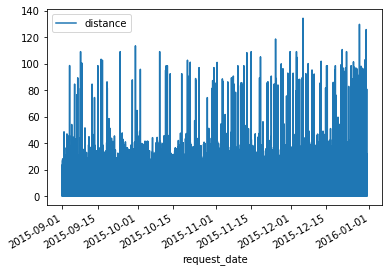

In [25]:
data.plot(x='request_date', y='source_latitude')
data.plot(x='request_date', y='source_longitude')
data.plot(x='request_date', y='source_x')
data.plot(x='request_date', y='source_y')
data.plot(x='request_date', y='source_z')
data.plot(x='request_date', y='destination_latitude')
data.plot(x='request_date', y='destination_longitude')
data.plot(x='request_date', y='destination_x')
data.plot(x='request_date', y='destination_y')
data.plot(x='request_date', y='destination_z')
data.plot(x='request_date', y='distance')

As we can observe, there are many requests that add noise to our data, which means that **source** or **destination** are far away from Lima (we can see it also from the **distance** plot which contains distances above 100km). When we want to predict the volume of passenger requests, we want to keep the requests that are not rare and they follow periodicity which means that they are repeated in specific amount of time. We can also check how many passengers make a small number of requests. As we observed there are passengers in our dataset that have called taxi only once in 4 months! So let's remove the outliers according to thresholds that stem from the above diagrams. We choose thresholds carefully in order not to throw just big values. If the big values are periodic, they are useful for our model.

In [26]:
source_lat_threshold = -12.35
source_long_threshold = -76.7
source_x_threshold = 1430
source_y_threshold = -6060
source_z_threshold = -1370
dest_lat_threshold = -12.8
dest_long_threshold = -76.55
dest_x_threshold = 1445
dest_y_threshold = -6043
dest_z_threshold = -1417
pass_requests_threshold = 10
distance_threshold = 90
data.shape

(2036062, 13)

We create a dataframe that contains all passenger ids with the respective volume of requests and then we remove those that have called taxi less than 10 times.

In [27]:
psng = pd.DataFrame(df.passenger_id.value_counts())
psng.reset_index(inplace=True)
psng.columns = ['passenger_id', 'requests']
psng.head()

passenger_id  requests
0         76772      1752
1        188719      1499
2        124189      1289
3         95667      1233
4         28420      1044

In [28]:
psng.shape

(118256, 2)

In [29]:
outlier_passengers = psng[psng['requests'] < pass_requests_threshold]
outlier_passengers.shape

(73137, 2)

We see that passengers with less than 10 requests in 4 months are almost the 60% of the passengers. By removing them we will lose information and the dataset will be decreased a lot. The requests are not based on passengers that call taxi frequently, so we will keep them all. Now let's remove the other outliers and see the effect on the dataset.

In [30]:
data = data[data['source_latitude'] >= source_lat_threshold]
data.shape

(2035928, 13)

In [31]:
data = data[data['source_longitude'] <= source_long_threshold]
data.shape

(2035897, 13)

In [32]:
data = data[data['source_x'] <= source_x_threshold]
data.shape

(2035888, 13)

In [33]:
data = data[data['source_y'] <= source_y_threshold]
data.shape

(2035888, 13)

In [34]:
data = data[data['source_z'] >= source_z_threshold]
data.shape

(2035888, 13)

In [35]:
data = data[data['destination_latitude'] >= dest_lat_threshold]
data.shape

(2035836, 13)

In [36]:
data = data[data['destination_longitude'] <= dest_long_threshold]
data.shape

(2035836, 13)

In [37]:
data = data[data['destination_x'] <= dest_x_threshold]
data.shape

(2035836, 13)

In [38]:
data = data[data['destination_y'] <= dest_y_threshold]
data.shape

(2035836, 13)

In [39]:
data = data[data['destination_z'] >= dest_z_threshold]
data.shape

(2035836, 13)

In [40]:
data = data[data['distance'] <= distance_threshold]
data.shape

(2035797, 13)

Finally we see that using these thresholds which remove the biggest outliers, our dataset is not decreased importantly. We now handle **2.035.797** rows instead of **2.045.260**. Let's view our features again after the outliers' extraction.

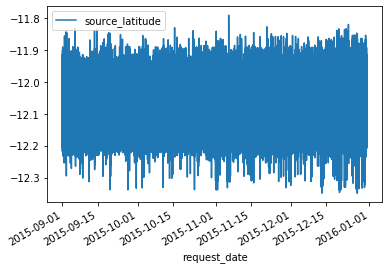

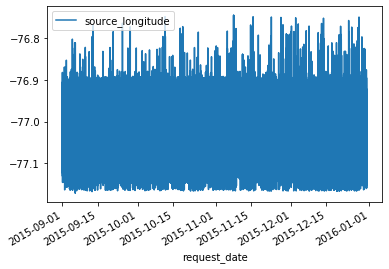

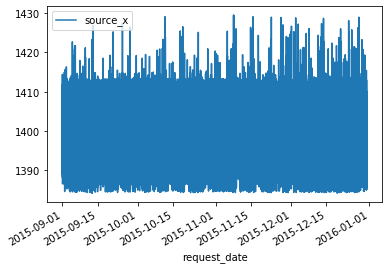

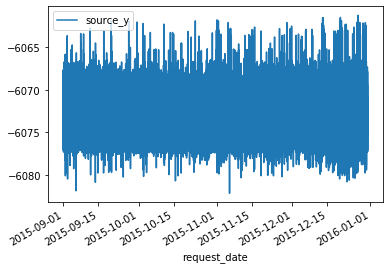

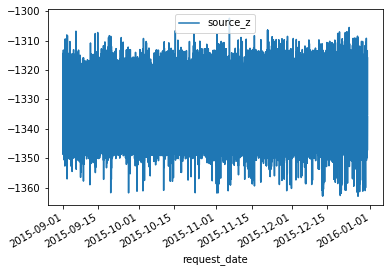

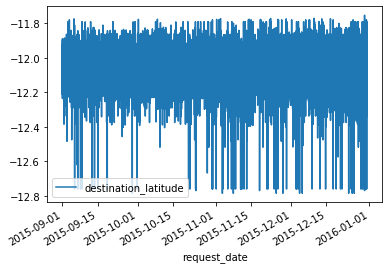

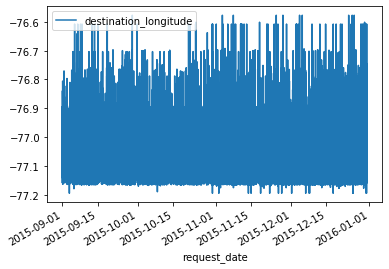

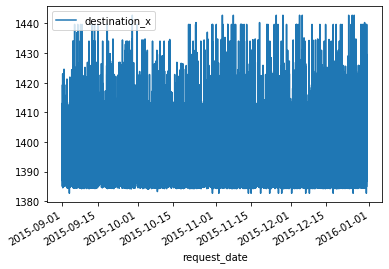

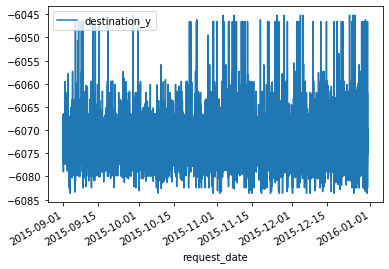

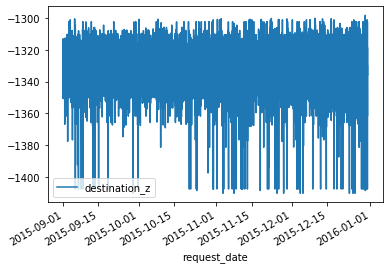

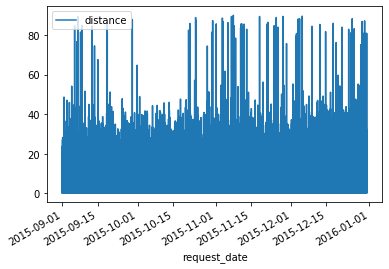

In [41]:
data.plot(x='request_date', y='source_latitude')
data.plot(x='request_date', y='source_longitude')
data.plot(x='request_date', y='source_x')
data.plot(x='request_date', y='source_y')
data.plot(x='request_date', y='source_z')
data.plot(x='request_date', y='destination_latitude')
data.plot(x='request_date', y='destination_longitude')
data.plot(x='request_date', y='destination_x')
data.plot(x='request_date', y='destination_y')
data.plot(x='request_date', y='destination_z')
data.plot(x='request_date', y='distance')

We can also check the source and destination points on the map, before and after the removal of outlier values. Below we create a function for viewing routes in Lima according to specific time-stamps. Blue points are the sources and red points are the destinations. For this purpose we will check for dates that contain outlier latitudes or longitudes and we will compare the maps with and without these points.

In [42]:
def get_map(df, lower_date, upper_date, connections=True):
    
    lower_date = pd.to_datetime(lower_date)
    upper_date = pd.to_datetime(upper_date)
    
    map_df = df[(lower_date <= df['request_date']) & (df['request_date'] <= upper_date)]
    
    lima_latitude = -12.046374
    lima_longitude = -77.042793

    lima_map = folium.Map(
            location=[lima_latitude,lima_longitude],
            tiles='cartodbpositron',
            zoom_start=12,
            )

    for _, row in map_df.iterrows():
        folium.CircleMarker([row['source_latitude'], row['source_longitude']],
                            radius=8,
                            fill_color="#3db7e4",
                           ).add_to(lima_map)

        folium.CircleMarker([row['destination_latitude'], row['destination_longitude']],
                            radius=8,
                            fill_color="red",
                           ).add_to(lima_map)

        if connections:
            folium.PolyLine([[row['source_latitude'], row['source_longitude']], 
                             [row['destination_latitude'], row['destination_longitude']]]).add_to(lima_map)
    return lima_map

In [43]:
lower_date = '2015-11-01 15:44:00'
upper_date = '2015-11-01 16:00:00'
get_map(df, lower_date, upper_date)

If we zoom out, we observe that we have a route far away from the city of Lima. These latitude and longitude values add noise to our data, they are not periodic and therefore they will have effect on the values that will enter our predictive model after rescaling. We want to predict the volume of requests per time, so we don't lose information by removing some points far away from Lima, because our model will be trained with input values being in smaller range.

In [44]:
get_map(data, lower_date, upper_date)

The above map, is the map after removing outliers and if we zoom out we observe that the previous route which is far away from the city does not exist. We are ready now to handle the requests that happen in a closer range of the city, in which we have the most important information and the most requests.

Below we have a function for resampling the data-frame and compute the average latitudes, longitudes and distances in the provided time-frame according to sampling rate.

In [45]:
def reformat_df(df, sampling_rate):
    df = df.set_index('request_date')
    df['requests'] = np.ones(shape = data.shape[0])
    requests_df = pd.DataFrame(df.resample(sampling_rate).sum())
    
    features = list(df.columns)
    features.remove('requests')
    # Compute average features
    for feature in features:
        requests_df[feature] = requests_df[feature] / requests_df['requests']

    requests_df.reset_index(inplace=True)
    
    # Remove last row (1 request)
    requests_df = requests_df[:-1]
    requests_df = requests_df.dropna()
    return requests_df

We are resampling the data according to sampling rate, which means that we can have requests per different time frames. We will check different sampling rates (1hour, 10min, 5min, 1min) and we will decide which we are going to use for our model.

In [46]:
del data['passenger_id']
data.head()


source_latitude  source_longitude     source_x     source_y     source_z  \
0       -12.088156        -77.016065  1400.122360 -6072.363628 -1334.610935   
1       -12.099957        -77.036497  1397.895137 -6072.594525 -1335.894425   
2       -12.099153        -77.019425  1399.708692 -6072.196002 -1335.806983   
3       -12.110271        -77.028945  1398.641537 -6072.175779 -1337.016140   
4       -12.098430        -77.026246  1398.989578 -6072.379018 -1335.728350   

   destination_latitude  destination_longitude  destination_x  destination_y  \
0            -12.108531             -77.044891    1396.960637   -6072.604367   
1            -12.119686             -76.999969    1401.662778   -6071.253519   
2            -12.076505             -77.089305    1392.419652   -6074.412818   
3            -12.132221             -77.027021    1398.730351   -6071.629227   
4            -12.099529             -76.990486    1402.773490   -6071.479720   

   destination_z  distance        request_date  
0   -1336.826907  3.868460 2015-09-01 00:00:04  
1   -1338.040046  4.538403 2015-09-01 00:00:15  
2   -1333.343704  8.007005 2015-09-01 00:00:17  
3   -1339.403203  2.450444 2015-09-01 00:00:29  
4   -1335.847876  3.891145 2015-09-01 00:00:31

In [47]:
sampling_rate = '60Min'
requests_df_60min = reformat_df(data, sampling_rate)
print(requests_df_60min.shape)
requests_df_60min.head()

(2904, 13)


request_date  source_latitude  source_longitude     source_x  \
0 2015-09-01 00:00:00       -12.097731        -77.023380  1399.296470   
1 2015-09-01 01:00:00       -12.099797        -77.021789  1399.454205   
2 2015-09-01 02:00:00       -12.093536        -77.025105  1399.135339   
3 2015-09-01 03:00:00       -12.091578        -77.014611  1400.257899   
4 2015-09-01 04:00:00       -12.096411        -77.025388  1399.090388   

      source_y     source_z  destination_latitude  destination_longitude  \
0 -6072.323350 -1335.652136            -12.098785             -77.021705   
1 -6072.237077 -1335.876819            -12.093043             -77.025037   
2 -6072.459819 -1335.195781            -12.091134             -77.026450   
3 -6072.247732 -1334.982853            -12.092325             -77.032621   
4 -6072.401602 -1335.508538            -12.094781             -77.024308   

   destination_x  destination_y  destination_z  distance  requests  
0    1399.468134   -6072.257427   -1335.766714  6.005946     708.0  
1    1399.145017   -6072.468574   -1335.142104  6.518740     479.0  
2    1399.005073   -6072.546085   -1334.934453  6.918081     492.0  
3    1398.344652   -6072.669277   -1335.064085  8.028501     563.0  
4    1399.212957   -6072.410824   -1335.331087  7.024629     355.0

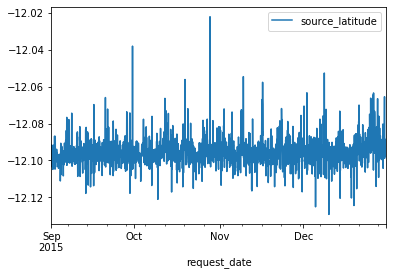

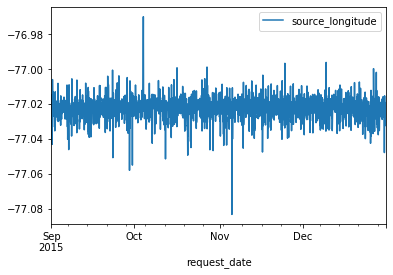

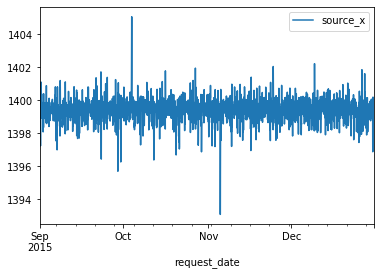

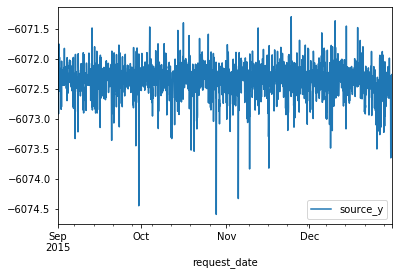

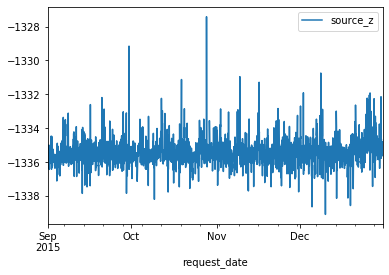

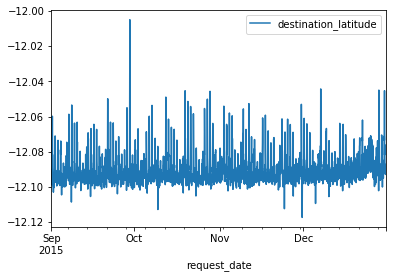

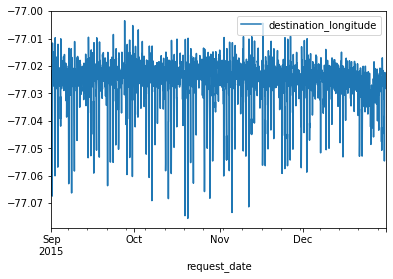

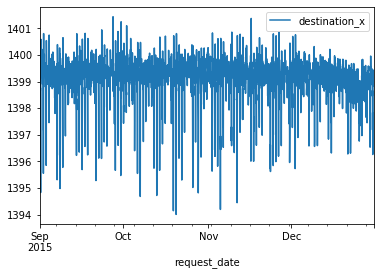

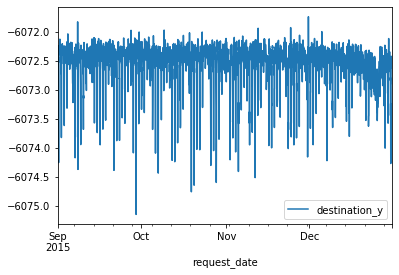

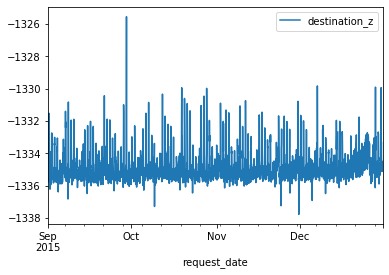

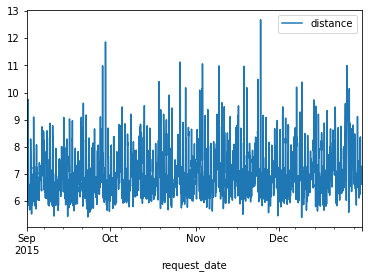

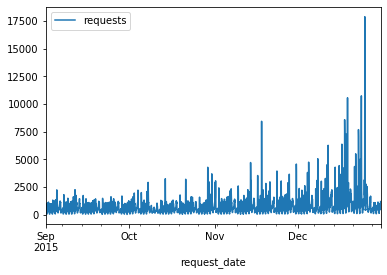

In [48]:
requests_df_60min.plot(x='request_date', y='source_latitude')
requests_df_60min.plot(x='request_date', y='source_longitude')
requests_df_60min.plot(x='request_date', y='source_x')
requests_df_60min.plot(x='request_date', y='source_y')
requests_df_60min.plot(x='request_date', y='source_z')
requests_df_60min.plot(x='request_date', y='destination_latitude')
requests_df_60min.plot(x='request_date', y='destination_longitude')
requests_df_60min.plot(x='request_date', y='destination_x')
requests_df_60min.plot(x='request_date', y='destination_y')
requests_df_60min.plot(x='request_date', y='destination_z')
requests_df_60min.plot(x='request_date', y='distance')
requests_df_60min.plot(x='request_date', y='requests')

In [49]:
sampling_rate = '10Min'
requests_df_10min = reformat_df(data, sampling_rate)
print(requests_df_10min.shape)
requests_df_10min.head()

(17416, 13)


request_date  source_latitude  source_longitude     source_x  \
0 2015-09-01 00:00:00       -12.098718        -77.021715  1399.467903   
1 2015-09-01 00:10:00       -12.096993        -77.025289  1399.097967   
2 2015-09-01 00:20:00       -12.097466        -77.019447  1399.714830   
3 2015-09-01 00:30:00       -12.096973        -77.023505  1399.287267   
4 2015-09-01 00:40:00       -12.093608        -77.025597  1399.083177   

      source_y     source_z  destination_latitude  destination_longitude  \
0 -6072.260458 -1335.759540            -12.101849             -77.020400   
1 -6072.386545 -1335.571933            -12.104215             -77.016887   
2 -6072.233552 -1335.623387            -12.098928             -77.023733   
3 -6072.343887 -1335.569730            -12.100930             -77.019408   
4 -6072.470961 -1335.203778            -12.089238             -77.030301   

   destination_x  destination_y  destination_z  distance  requests  
0    1399.590599   -6072.156590   -1336.100033  5.286146     115.0  
1    1399.950407   -6072.016536   -1336.357251  6.089489     145.0  
2    1399.252436   -6072.303770   -1335.782349  5.538262     131.0  
3    1399.700237   -6072.152317   -1335.999982  6.147932     108.0  
4    1398.606961   -6072.683894   -1334.728323  6.849081     111.0

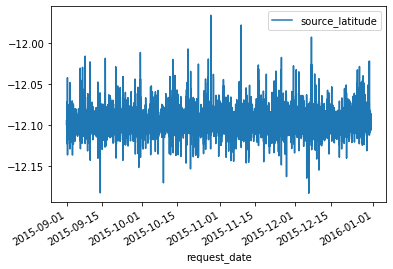

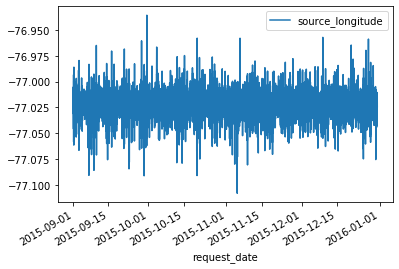

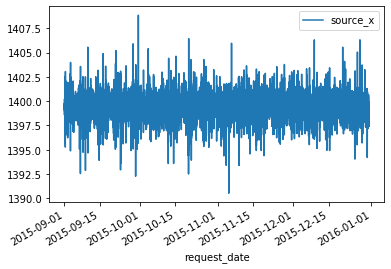

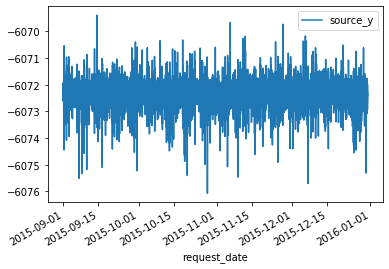

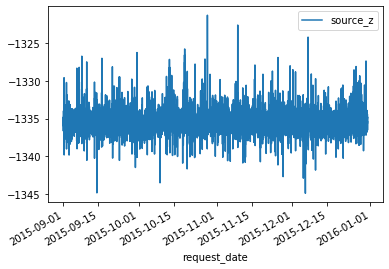

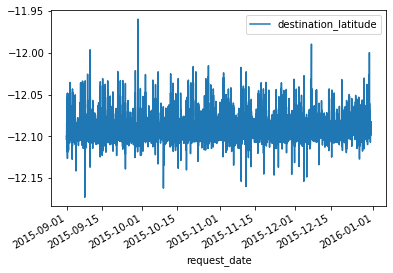

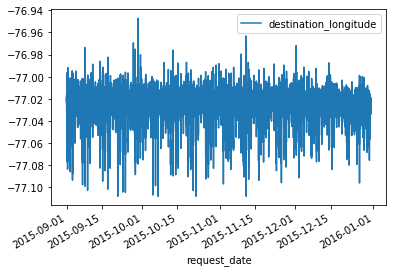

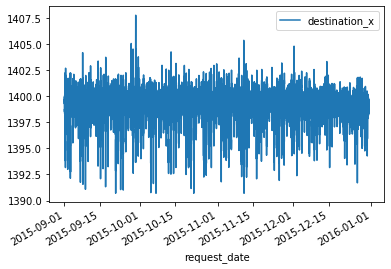

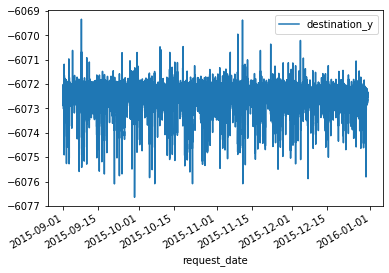

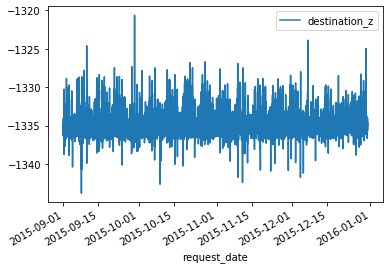

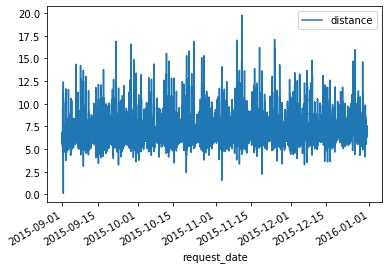

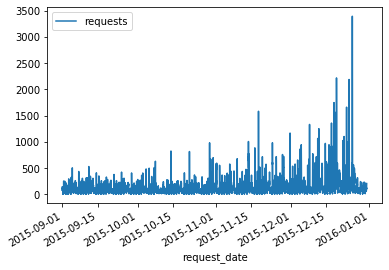

In [50]:
requests_df_10min.plot(x='request_date', y='source_latitude')
requests_df_10min.plot(x='request_date', y='source_longitude')
requests_df_10min.plot(x='request_date', y='source_x')
requests_df_10min.plot(x='request_date', y='source_y')
requests_df_10min.plot(x='request_date', y='source_z')
requests_df_10min.plot(x='request_date', y='destination_latitude')
requests_df_10min.plot(x='request_date', y='destination_longitude')
requests_df_10min.plot(x='request_date', y='destination_x')
requests_df_10min.plot(x='request_date', y='destination_y')
requests_df_10min.plot(x='request_date', y='destination_z')
requests_df_10min.plot(x='request_date', y='distance')
requests_df_10min.plot(x='request_date', y='requests')

In [51]:
sampling_rate = '5Min'
requests_df_5min = reformat_df(data, sampling_rate)
print(requests_df_5min.shape)
requests_df_5min.head()

(34790, 13)


request_date  source_latitude  source_longitude     source_x  \
0 2015-09-01 00:00:00       -12.097650        -77.023250  1399.310787   
1 2015-09-01 00:05:00       -12.099967        -77.019919  1399.651698   
2 2015-09-01 00:10:00       -12.097578        -77.023892  1399.242947   
3 2015-09-01 00:15:00       -12.096367        -77.026786  1398.942631   
4 2015-09-01 00:20:00       -12.094567        -77.020405  1399.628448   

      source_y     source_z  destination_latitude  destination_longitude  \
0 -6072.322229 -1335.643371            -12.099725             -77.034887   
1 -6072.188197 -1335.895436            -12.104334             -77.003453   
2 -6072.339056 -1335.635489            -12.106151             -77.012550   
3 -6072.437427 -1335.503837            -12.102140             -77.021535   
4 -6072.322764 -1335.308067            -12.106344             -77.017887   

   destination_x  destination_y  destination_z  distance  requests  
0    1398.066253   -6072.558557   -1335.868982  5.395896      62.0  
1    1401.373795   -6071.686364   -1336.370319  5.157760      53.0  
2    1400.399939   -6071.866595   -1336.567811  6.428841      75.0  
3    1399.468765   -6072.177188   -1336.131651  5.725896      70.0  
4    1399.833290   -6071.992692   -1336.588898  5.493878      73.0

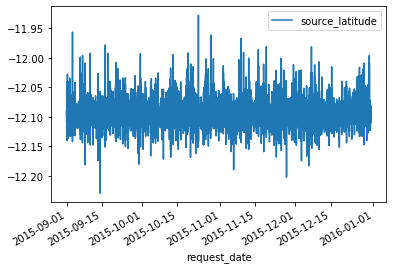

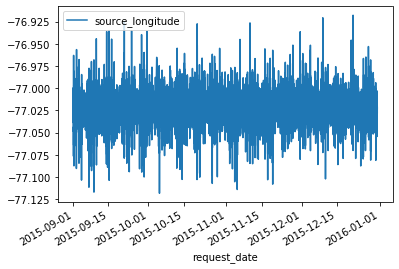

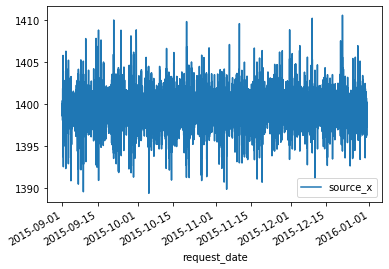

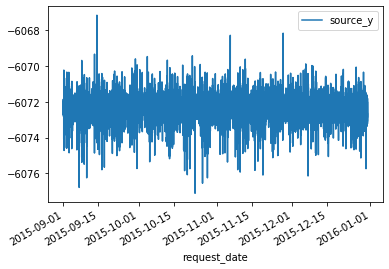

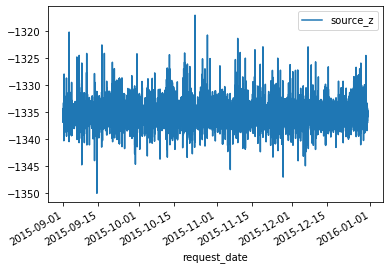

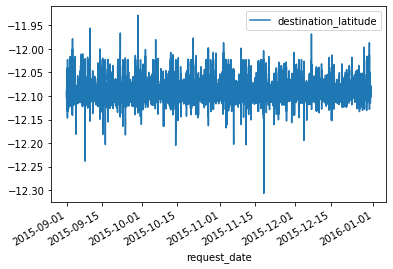

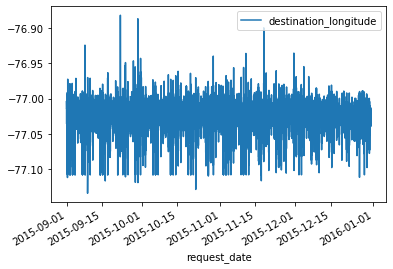

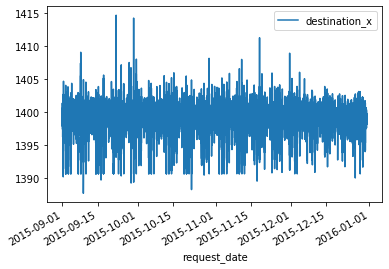

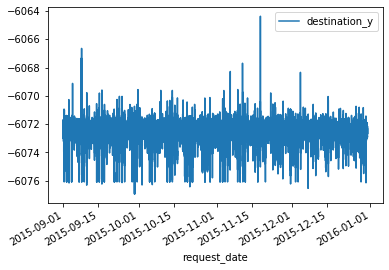

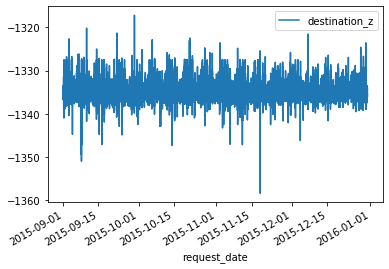

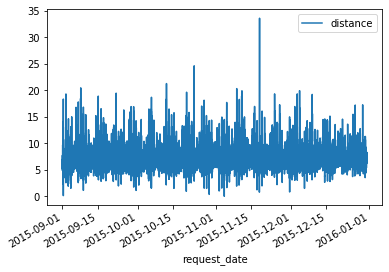

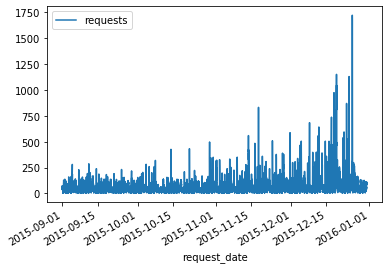

In [52]:
requests_df_5min.plot(x='request_date', y='source_latitude')
requests_df_5min.plot(x='request_date', y='source_longitude')
requests_df_5min.plot(x='request_date', y='source_x')
requests_df_5min.plot(x='request_date', y='source_y')
requests_df_5min.plot(x='request_date', y='source_z')
requests_df_5min.plot(x='request_date', y='destination_latitude')
requests_df_5min.plot(x='request_date', y='destination_longitude')
requests_df_5min.plot(x='request_date', y='destination_x')
requests_df_5min.plot(x='request_date', y='destination_y')
requests_df_5min.plot(x='request_date', y='destination_z')
requests_df_5min.plot(x='request_date', y='distance')
requests_df_5min.plot(x='request_date', y='requests')

In [53]:
sampling_rate = '1Min'
requests_df_1min = reformat_df(data, sampling_rate)
print(requests_df_1min.shape)
requests_df_1min.head()

(167030, 13)


request_date  source_latitude  source_longitude     source_x  \
0 2015-09-01 00:00:00       -12.100928        -77.024121  1399.201643   
1 2015-09-01 00:01:00       -12.109925        -77.023429  1399.227428   
2 2015-09-01 00:02:00       -12.094965        -77.027078  1398.919305   
3 2015-09-01 00:03:00       -12.086763        -77.029867  1398.666132   
4 2015-09-01 00:04:00       -12.100766        -77.012815  1400.400628   

      source_y     source_z  destination_latitude  destination_longitude  \
0 -6072.269917 -1335.999929            -12.105575             -77.032900   
1 -6072.047717 -1336.978406            -12.112761             -77.014624   
2 -6072.476813 -1335.351442            -12.085276             -77.050061   
3 -6072.730095 -1334.459253            -12.105962             -77.032405   
4 -6071.996859 -1335.982287            -12.095667             -77.036525   

   destination_x  destination_y  destination_z  distance  requests  
0    1398.246542   -6072.377883   -1336.505393  4.593490      10.0  
1    1400.145221   -6071.765866   -1337.286581  5.271990       9.0  
2    1396.533404   -6073.256791   -1334.297545  5.547896      14.0  
3    1398.296927   -6072.356794   -1336.547332  6.035336      14.0  
4    1397.914045   -6072.691250   -1335.427697  5.266499      15.0

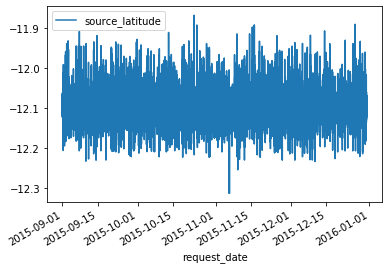

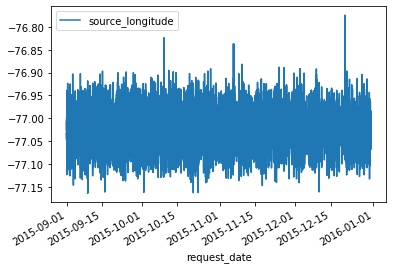

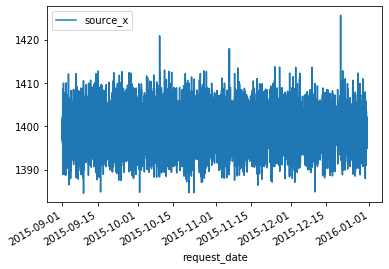

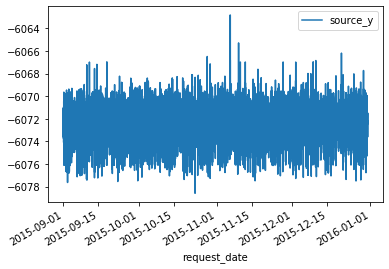

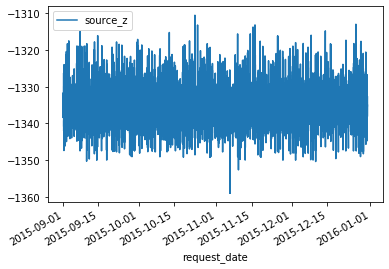

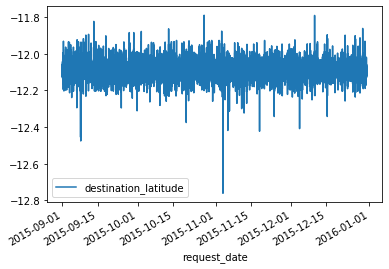

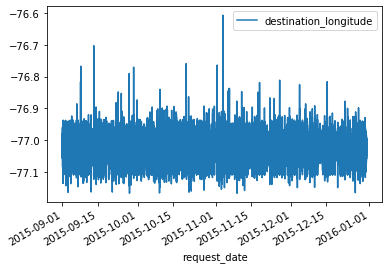

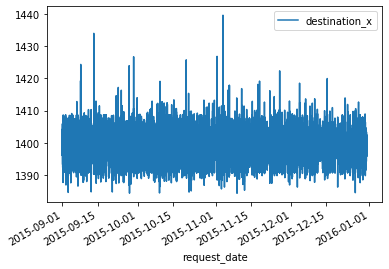

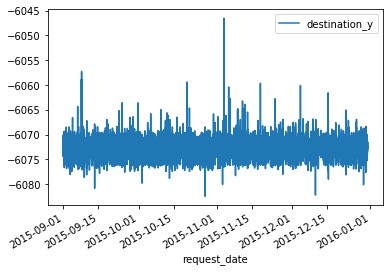

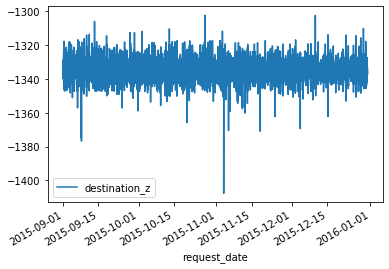

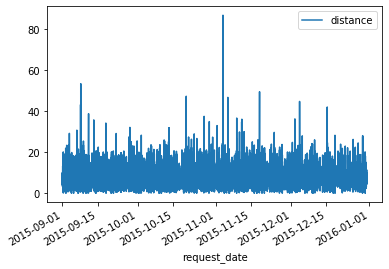

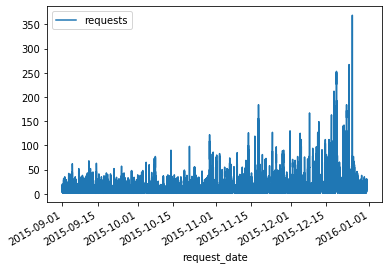

In [54]:
requests_df_1min.plot(x='request_date', y='source_latitude')
requests_df_1min.plot(x='request_date', y='source_longitude')
requests_df_1min.plot(x='request_date', y='source_x')
requests_df_1min.plot(x='request_date', y='source_y')
requests_df_1min.plot(x='request_date', y='source_z')
requests_df_1min.plot(x='request_date', y='destination_latitude')
requests_df_1min.plot(x='request_date', y='destination_longitude')
requests_df_1min.plot(x='request_date', y='destination_x')
requests_df_1min.plot(x='request_date', y='destination_y')
requests_df_1min.plot(x='request_date', y='destination_z')
requests_df_1min.plot(x='request_date', y='distance')
requests_df_1min.plot(x='request_date', y='requests')

In [55]:
data.head()

source_latitude  source_longitude     source_x     source_y     source_z  \
0       -12.088156        -77.016065  1400.122360 -6072.363628 -1334.610935   
1       -12.099957        -77.036497  1397.895137 -6072.594525 -1335.894425   
2       -12.099153        -77.019425  1399.708692 -6072.196002 -1335.806983   
3       -12.110271        -77.028945  1398.641537 -6072.175779 -1337.016140   
4       -12.098430        -77.026246  1398.989578 -6072.379018 -1335.728350   

   destination_latitude  destination_longitude  destination_x  destination_y  \
0            -12.108531             -77.044891    1396.960637   -6072.604367   
1            -12.119686             -76.999969    1401.662778   -6071.253519   
2            -12.076505             -77.089305    1392.419652   -6074.412818   
3            -12.132221             -77.027021    1398.730351   -6071.629227   
4            -12.099529             -76.990486    1402.773490   -6071.479720   

   destination_z  distance        request_date  
0   -1336.826907  3.868460 2015-09-01 00:00:04  
1   -1338.040046  4.538403 2015-09-01 00:00:15  
2   -1333.343704  8.007005 2015-09-01 00:00:17  
3   -1339.403203  2.450444 2015-09-01 00:00:29  
4   -1335.847876  3.891145 2015-09-01 00:00:31

We can view the routes before counting the requests in specific time-stamps

In [56]:
# 'Plug and play' code to check the routes of requests on time-stamps we want
lower_date = '2015-10-01 23:00:00'
upper_date = '2015-10-01 23:59:00'
# We set connections to false to get a clear view of the points
get_map(data, lower_date, upper_date, connections=False)

In this time-frame of 1 hour, it's not clear where the most requests are taking place. So we can view the average positions of these requests using the data-frames after counting requests. Using bigger sampling rate we get less routes and more requests/sampling_rate.

In [57]:
get_map(requests_df_1min, lower_date, upper_date)

In [58]:
get_map(requests_df_5min, lower_date, upper_date)

In [59]:
get_map(requests_df_10min, lower_date, upper_date)

In [60]:
get_map(requests_df_60min, lower_date, upper_date)

We can now take a look at the correlation matrix of the features we have

In [61]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaled_data = requests_df_5min.copy()
features = ['source_latitude', 
            'source_longitude', 
            'source_x', 
            'source_y', 
            'source_z', 
            'destination_latitude', 
            'destination_longitude', 
            'destination_x', 
            'destination_y', 
            'destination_z', 
            'distance', 
            'requests']
for feature in features:
    scaled_data[feature] = scaler.fit_transform(scaled_data[[feature]])
    
scaled_data.head()


request_date  source_latitude  source_longitude  source_x  source_y  \
0 2015-09-01 00:00:00         0.436958          0.474489  0.468153  0.482005   
1 2015-09-01 00:05:00         0.429281          0.491096  0.484231  0.495510   
2 2015-09-01 00:10:00         0.437196          0.471291  0.464953  0.480309   
3 2015-09-01 00:15:00         0.441206          0.456863  0.450790  0.470397   
4 2015-09-01 00:20:00         0.447171          0.488671  0.483135  0.481951   

   source_z  destination_latitude  destination_longitude  destination_x  \
0  0.436793              0.546983               0.393646       0.383250   
1  0.429117              0.534806               0.518089       0.506369   
2  0.437033              0.530006               0.482075       0.470119   
3  0.441042              0.540602               0.446506       0.435457   
4  0.447004              0.529495               0.460948       0.449026   

   destination_y  destination_z  distance  requests  
0       0.349706       0.546564  0.160478  0.035424  
1       0.418951       0.534379  0.153396  0.030197  
2       0.404642       0.529578  0.191198  0.042973  
3       0.379984       0.540180  0.170292  0.040070  
4       0.394631       0.529066  0.163392  0.041812

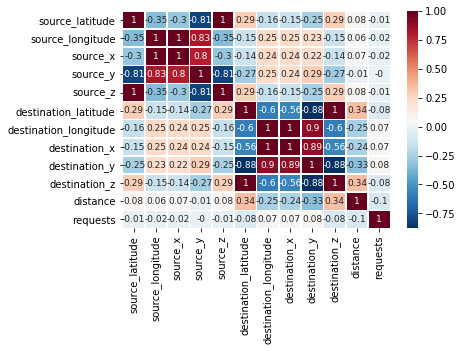

In [62]:
correlation_matrix = scaled_data.corr()
correlation_matrix = correlation_matrix.apply(lambda x: np.around(x, decimals=2))

import seaborn as sb

sb.heatmap(correlation_matrix, 
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            annot_kws={"size": 9})



Unfortunately, our heatmap does not provide any indication of significant correlation between our new variables. But again, that doesn’t mean there is no relationship at all between them, it just means there is no significant linear relationship.

In [63]:
split_date = pd.to_datetime('2015-12-15 00:00:00')
train_df = scaled_data[scaled_data.request_date < split_date]
test_df = scaled_data[scaled_data.request_date >= split_date]

In [64]:
train_df.head()

request_date  source_latitude  source_longitude  source_x  source_y  \
0 2015-09-01 00:00:00         0.436958          0.474489  0.468153  0.482005   
1 2015-09-01 00:05:00         0.429281          0.491096  0.484231  0.495510   
2 2015-09-01 00:10:00         0.437196          0.471291  0.464953  0.480309   
3 2015-09-01 00:15:00         0.441206          0.456863  0.450790  0.470397   
4 2015-09-01 00:20:00         0.447171          0.488671  0.483135  0.481951   

   source_z  destination_latitude  destination_longitude  destination_x  \
0  0.436793              0.546983               0.393646       0.383250   
1  0.429117              0.534806               0.518089       0.506369   
2  0.437033              0.530006               0.482075       0.470119   
3  0.441042              0.540602               0.446506       0.435457   
4  0.447004              0.529495               0.460948       0.449026   

   destination_y  destination_z  distance  requests  
0       0.349706       0.546564  0.160478  0.035424  
1       0.418951       0.534379  0.153396  0.030197  
2       0.404642       0.529578  0.191198  0.042973  
3       0.379984       0.540180  0.170292  0.040070  
4       0.394631       0.529066  0.163392  0.041812

In [65]:
train_df.tail()

request_date  source_latitude  source_longitude  source_x  \
30235 2015-12-14 23:35:00         0.434156          0.490564  0.484062   
30236 2015-12-14 23:40:00         0.444022          0.490055  0.484293   
30237 2015-12-14 23:45:00         0.444607          0.503928  0.498248   
30238 2015-12-14 23:50:00         0.444250          0.459272  0.453443   
30239 2015-12-14 23:55:00         0.444601          0.442374  0.436518   

       source_y  source_z  destination_latitude  destination_longitude  \
30235  0.491877  0.433992              0.538861               0.455556   
30236  0.484787  0.443857              0.545930               0.431699   
30237  0.491232  0.444441              0.574680               0.417551   
30238  0.469419  0.444083              0.582694               0.414397   
30239  0.460882  0.444437              0.579224               0.444364   

       destination_x  destination_y  destination_z  distance  requests  
30235       0.444350       0.385573       0.538437  0.171837  0.098142  
30236       0.421092       0.369088       0.545514  0.173436  0.145180  
30237       0.409112       0.342555       0.574279  0.164591  0.202091  
30238       0.406554       0.335562       0.582301  0.163551  0.207898  
30239       0.436165       0.352605       0.578827  0.200610  0.149826

In [66]:
test_df.head()

request_date  source_latitude  source_longitude  source_x  \
30240 2015-12-15 00:00:00         0.435383          0.460930  0.454438   
30241 2015-12-15 00:05:00         0.434554          0.464125  0.457585   
30242 2015-12-15 00:10:00         0.431830          0.503676  0.497033   
30243 2015-12-15 00:15:00         0.437720          0.472230  0.465944   
30244 2015-12-15 00:20:00         0.436211          0.457082  0.450641   

       source_y  source_z  destination_latitude  destination_longitude  \
30240  0.476410  0.435220              0.568592               0.433883   
30241  0.478528  0.434389              0.568094               0.414674   
30242  0.499985  0.431665              0.539247               0.453710   
30243  0.480358  0.437555              0.560486               0.407745   
30244  0.473932  0.436048              0.565877               0.433156   

       destination_x  destination_y  destination_z  distance  requests  
30240       0.424941       0.354703       0.568188  0.190283  0.106272  
30241       0.405754       0.345652       0.567691  0.171235  0.114402  
30242       0.442536       0.384415       0.538824  0.182809  0.113240  
30243       0.398283       0.347489       0.560080  0.189246  0.134146  
30244       0.424014       0.356202       0.565471  0.168283  0.135308

In [67]:
test_df.tail()

request_date  source_latitude  source_longitude  source_x  \
34843 2015-12-30 23:35:00         0.428388          0.485067  0.478102   
34844 2015-12-30 23:40:00         0.444893          0.503817  0.498141   
34845 2015-12-30 23:45:00         0.447138          0.470900  0.465294   
34846 2015-12-30 23:50:00         0.427516          0.486072  0.479056   
34847 2015-12-30 23:55:00         0.460872          0.453539  0.448909   

       source_y  source_z  destination_latitude  destination_longitude  \
34843  0.493244  0.428229              0.561760               0.412262   
34844  0.491085  0.444731              0.558638               0.425891   
34845  0.473328  0.446978              0.565151               0.396049   
34846  0.494291  0.427354              0.554732               0.434338   
34847  0.455262  0.460709              0.557755               0.442340   

       destination_x  destination_y  destination_z  distance  requests  
34843       0.402861       0.348907       0.561358  0.228495  0.049361  
34844       0.416236       0.357608       0.558232  0.207754  0.047619  
34845       0.386971       0.338577       0.564748  0.199452  0.051684  
34846       0.424370       0.364379       0.554320  0.193090  0.059233  
34847       0.432447       0.366844       0.557378  0.240605  0.058653

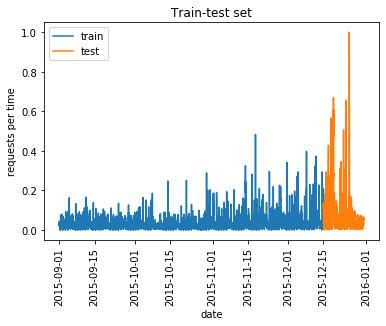

In [71]:
plt.plot(train_df['request_date'], train_df['requests'], label='train')
plt.plot(test_df['request_date'], test_df['requests'], label='test')
plt.title('Train-test set')
plt.xlabel('date')
plt.xticks(rotation=90)
plt.ylabel('requests per time')
plt.legend()
plt.show()

In [72]:
def window_data(dataset, target, start_index, end_index, history_size,
                target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [73]:
train_data = train_df[features]
train_data.index = train_df['request_date']
test_data = test_df[features]
test_data.index = test_df['request_date']

train_data.head()

source_latitude  source_longitude  source_x  source_y  \
request_date                                                                 
2015-09-01 00:00:00         0.436958          0.474489  0.468153  0.482005   
2015-09-01 00:05:00         0.429281          0.491096  0.484231  0.495510   
2015-09-01 00:10:00         0.437196          0.471291  0.464953  0.480309   
2015-09-01 00:15:00         0.441206          0.456863  0.450790  0.470397   
2015-09-01 00:20:00         0.447171          0.488671  0.483135  0.481951   

                     source_z  destination_latitude  destination_longitude  \
request_date                                                                 
2015-09-01 00:00:00  0.436793              0.546983               0.393646   
2015-09-01 00:05:00  0.429117              0.534806               0.518089   
2015-09-01 00:10:00  0.437033              0.530006               0.482075   
2015-09-01 00:15:00  0.441042              0.540602               0.446506   
2015-09-01 00:20:00  0.447004              0.529495               0.460948   

                     destination_x  destination_y  destination_z  distance  \
request_date                                                                 
2015-09-01 00:00:00       0.383250       0.349706       0.546564  0.160478   
2015-09-01 00:05:00       0.506369       0.418951       0.534379  0.153396   
2015-09-01 00:10:00       0.470119       0.404642       0.529578  0.191198   
2015-09-01 00:15:00       0.435457       0.379984       0.540180  0.170292   
2015-09-01 00:20:00       0.449026       0.394631       0.529066  0.163392   

                     requests  
request_date                   
2015-09-01 00:00:00  0.035424  
2015-09-01 00:05:00  0.030197  
2015-09-01 00:10:00  0.042973  
2015-09-01 00:15:00  0.040070  
2015-09-01 00:20:00  0.041812

In [74]:
test_data.head()

source_latitude  source_longitude  source_x  source_y  \
request_date                                                                 
2015-12-15 00:00:00         0.435383          0.460930  0.454438  0.476410   
2015-12-15 00:05:00         0.434554          0.464125  0.457585  0.478528   
2015-12-15 00:10:00         0.431830          0.503676  0.497033  0.499985   
2015-12-15 00:15:00         0.437720          0.472230  0.465944  0.480358   
2015-12-15 00:20:00         0.436211          0.457082  0.450641  0.473932   

                     source_z  destination_latitude  destination_longitude  \
request_date                                                                 
2015-12-15 00:00:00  0.435220              0.568592               0.433883   
2015-12-15 00:05:00  0.434389              0.568094               0.414674   
2015-12-15 00:10:00  0.431665              0.539247               0.453710   
2015-12-15 00:15:00  0.437555              0.560486               0.407745   
2015-12-15 00:20:00  0.436048              0.565877               0.433156   

                     destination_x  destination_y  destination_z  distance  \
request_date                                                                 
2015-12-15 00:00:00       0.424941       0.354703       0.568188  0.190283   
2015-12-15 00:05:00       0.405754       0.345652       0.567691  0.171235   
2015-12-15 00:10:00       0.442536       0.384415       0.538824  0.182809   
2015-12-15 00:15:00       0.398283       0.347489       0.560080  0.189246   
2015-12-15 00:20:00       0.424014       0.356202       0.565471  0.168283   

                     requests  
request_date                   
2015-12-15 00:00:00  0.106272  
2015-12-15 00:05:00  0.114402  
2015-12-15 00:10:00  0.113240  
2015-12-15 00:15:00  0.134146  
2015-12-15 00:20:00  0.135308

In [75]:
train_data = train_data.values
test_data = test_data.values

In [77]:
history_size = 60
target_size = 1

print(train_data.shape)
print(test_data.shape)

x_train, y_train = window_data(train_data, train_data[:, 1],0, None,
                                       history_size, target_size, 1, single_step=True)
x_test, y_test = window_data(test_data, test_data[:, 1],0, None,
                                     history_size, target_size, 1, single_step=True)


print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)


(30182, 12)
(4608, 12)
(30121, 60, 12)
(30121,)
(4547, 60, 12)
(4547,)
